<a href="https://colab.research.google.com/github/mataney/PyTorchCourse/blob/master/2_training_a_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trainig a Classifier

Let's build a classification network.

We will do the following steps in order:

- Get familiar with torchvision
- Load and get familiar with the dataset, we will use the CIFAR10 training and test datasets using torchvision.
- Define a Neural Network  that has some learnable parameters (or weights).
- CUDA
- Define a loss function and optimizer
- Iterate over a dataset of inputs
- Train the network on the training data
- Test the network on the test data

## torchvision

The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision.

We will use `torchvision` for loading the CIFAR10 dataset.

In [0]:
import torch
import torchvision

We want to download the CIFAR10 dataset. we can do this by:
```
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
```

But,  
The output of torchvision datasets are PILImage, we want to recieve tensors.
Use `torchvision.transforms` for this

## Load and get familiar with CIFAR10

In [0]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor()])

In [0]:
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:08, 20182739.45it/s]                               


Files already downloaded and verified


In [0]:
print(trainset)
print(trainset[0])
print(f"size: {trainset[0][0].size()}")
print(f"class: {trainset[0][1]} ({classes[trainset[0][1]]})")

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.000

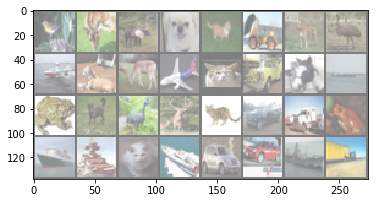

bird, deer, deer, dog, cat, truck, dog, bird, plane, dog, deer, plane, cat, truck, horse, ship, frog, dog, bird, deer, cat, truck, truck, frog, ship, ship, cat, ship, car, car, ship, truck,


In [0]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%s,' % classes[labels[j]] for j in range(len(labels))))

## Define the network

### nn.Module

After we had a glimpse of tensors and autograd, let's have a look on `torch.nn`:  
`torch.nn` depends on `autograd` to define models and differentiate them.  
An `nn.Module` requires to implement a `forward(input)` method that returns the `output`.  
The `backward` function (where gradients are computed) is automatically defined for you using `autograd`. You can use any of the Tensor operations in the `forward` function.



For example let's have a look on `nn.Linear`:  
This class applies a linear transformation to the incoming data: $y = xA^T + b$

In [0]:
??torch.nn.Linear

In [0]:
??torch.nn.Parameter

For now this is what we need to do. Let's implement a `nn.Module`.

Base class for all neural network modules.  
Your models should also subclass this class.  
This makes the associated `weights` to require grad, or `parameters`.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 100)
        self.linear2 = nn.Linear(50, 10) #BUG :)

    def forward(self, x):
        batch, channels, w, h = x.size()        
        x = self.linear1(x.view(batch, -1))
        x = torch.relu(x)
        x = self.linear2(x)
        return x


model = LinearModel()

## CUDA

If you recall, "PyTorch replacement for NumPy to use the power of GPUs".  
We want all our tensors from the model to be on the GPU and not on the CPU.  
How can we do this?

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
!nvidia-smi
model.to(device)
print(f"\nModel was uploaded to device {device}\n")
!nvidia-smi

Thu May 30 11:13:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    28W /  70W |    771MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Loss function and Optimizer

Now we need to ask ourselves 3 questions about the learning:
- What components in our model should be learned?
- With respect to what?
- How should we learn? (i.e., how should we update the learnable components)

Answers

**What components in our model should be learned?:**  
When we talked about `autograd` the gradient of the output was w.r.t the leaves (`x`).  
What are the leaves in a neural network?  
The learnable weights, or parameters, that is, the nn.Linear weigths etc.
The learnable parameters of a model are returned by `.parameters()`.  
Have a look:


In [0]:
[p.size() for p in model.parameters()]

[torch.Size([100, 3072]),
 torch.Size([100]),
 torch.Size([10, 100]),
 torch.Size([10])]

**With respect to what?**.  
As always, we are learning to minimize/maximize some loss/cost function, sometimes called "criterion".  
So this means we need to define one.

In [0]:
criterion = nn.CrossEntropyLoss()


**How should we learn? (i.e., how should we update the learnable components)**.  
We should update our weights with some optimizer, use Stochastic Gradient Descent for example.


In [0]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training loop

Let's write the most simple training loop:

In [0]:
??model.train()

In [0]:
def train(model, num_epochs, trainloader, optimizer, criterion, device):
  model.train() # This only sets a flag. This is relevent for component that ar
                # being using only in training (Dropout for example)
  for epoch in range(num_epochs):
      running_loss = 0.0 # loss for this epoch
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad() # zero the parameter gradients
          # backward() function accumulates gradients so you have to zero them
          # out at the start of a new minibatch.

          outputs = model(inputs) # forward
          loss = criterion(outputs, labels) # get loss
          loss.backward() # backward: calculates gradients
          optimizer.step() # optimize: Update Parameters wrt the gradients

          running_loss += loss.item() # print statistics
      print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(trainloader)))

  print('Finished Training')

In [0]:
num_epochs = 10
train(model, num_epochs, trainloader, optimizer, criterion, device)

[1] loss: 1.935
[2] loss: 1.764
[3] loss: 1.683
[4] loss: 1.627
[5] loss: 1.588
[6] loss: 1.557
[7] loss: 1.532
[8] loss: 1.507
[9] loss: 1.485
[10] loss: 1.464
Finished Training


### Test the network on the test data

In [0]:
def evaluate(model, dataloader, device):
  model.eval() # Switch the flag
  correct = 0
  total = 0
  with torch.no_grad():
      for data in dataloader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs) # forward
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [0]:
evaluate(model, testloader, device)

Accuracy of the network on the 10000 test images: 46 %


Well, it's better than flipping a 10-sided die

# Train you own network

What to do?

- Normalize the inputs such that the mean and standard deviation are 0, 1 respectively for each channel. (Do this with PyTorch native methods, `mean()`, `std()` etc')
- A more "sophisticated" model.

Skeleton in the next notebook